# Advent of Haystack: Day 3

_Make a copy of this Colab to start_

In this challenge, you must help Elf David build a system to answer questions over BBC news dataset. However, to increase recall, your system should be able to generate questions similar to the ones asked.

For instance, if Santa asks, `"How are cybersecurity threats evolving with new technologies?"` the system should be able to generate similar questions like:

- `"What impact do emerging technologies like AI and IoT have on the landscape of cybersecurity threats?"`
- `"How are organizations adapting their cybersecurity strategies in response to the evolution of threats driven by technological advancements?"`
- `"In what ways are cybercriminals leveraging new technologies to enhance their attack methods and tactics?"`

All these questions are similar to the original question, but they are not the same. The idea is that by generating similar questions, you can increase the system's recall, as the system will be able to retrieve more documents that could contain the answer to the original question.
For that, you will use a large language model (LLM) to generate alternative similar questions based on the original question.
Each of these similar questions will query a document store with news articles; all the documents retrieved by each similar question will be used to compose an answer to the original question.


### Components to use:

- [`InMemoryDocumentStore`](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore): to store the news articles.
- [`InMemoryEmbeddingRetriever`](https://docs.haystack.deepset.ai/docs/inmemoryembeddingretriever): to retrieve the documents from the document store.
- [`OpenAIGenerator`](https://docs.haystack.deepset.ai/docs/openaigenerator): to instantiate the LLM to generate similar questions and compose an answer to the original question.
- [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder): to build the prompts to query the LLM
- [`AnswerBuilder`](https://docs.haystack.deepset.ai/docs/answerbuilder): (optional) to build the answers to the original question.
- [`SentenceTransformersTextEmbedder`](https://docs.haystack.deepset.ai/docs/sentencetransformerstextembedder): to embed the questions
- [`SentenceTransformersDocumentEmbedder`](https://docs.haystack.deepset.ai/docs/sentencetransformersdocumentembedder): to embed the news articles
- [`DocumentJoiner`](https://docs.haystack.deepset.ai/docs/documentjoiner): to join the documents retrieved by similar query questions

### Your task is to build two custom components:

- `MultiQueryGenerator`: a custom component that uses an LLM to generate similar questions based on the original question.
- `MultiQueryHandler`: a custom component that queries the document store with a set of query questions and collects all the documents

**Note:** Feel free to change the models in this challenge and use different model providers.

### 1) Installation

Install packages and the BBC news dataset

In [1]:
!uv pip install haystack-ai "sentence-transformers>=3.0.0" lazy_imports
#!uv pip install -q --upgrade openai # not to get the OpenAI proxies error: https://community.openai.com/t/error-with-openai-1-56-0-client-init-got-an-unexpected-keyword-argument-proxies/1040332/2
!wget https://raw.githubusercontent.com/amankharwal/Website-data/master/bbc-news-data.csv

Audited 3 packages in 40ms
--2024-12-21 12:55:15--  https://raw.githubusercontent.com/amankharwal/Website-data/master/bbc-news-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5080260 (4.8M) [text/plain]
Saving to: ‘bbc-news-data.csv’

bbc-news-data.csv   100%[===================>]   4.84M  20.8MB/s    in 0.2s    

2024-12-21 12:55:16 (20.8 MB/s) - ‘bbc-news-data.csv’ saved [5080260/5080260]



### 2) Enter API keys for LLM
If you want to use OpenAI models, save your API key as `OPENAI_API_KEY` environment variable.

In [2]:
""" from getpass import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:") """

' from getpass import getpass\nimport os\n\nos.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:") '

### 3) Parse the news dataset and index it

In [3]:
import csv
from typing import List

from haystack import Document
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.writers import DocumentWriter
from haystack import Pipeline

def read_documents(file: str) -> List[Document]:
    with open(file, "r") as file:
        reader = csv.reader(file, delimiter="\t")
        next(reader, None)  # skip the headers
        docs = []
        for row in reader:
            category = row[0].strip()
            title = row[2].strip()
            text = row[3].strip()
            docs.append(Document(content=text, meta={"category": category, "title": title}))

    return docs


embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
doc_store = InMemoryDocumentStore()

indexing_pipeline = Pipeline()
indexing_pipeline.add_component("embedder", SentenceTransformersDocumentEmbedder(model=embedding_model))
indexing_pipeline.add_component("writer", DocumentWriter(doc_store, policy=DuplicatePolicy.OVERWRITE))
indexing_pipeline.connect("embedder", "writer")

documents = read_documents("bbc-news-data.csv")
indexing_pipeline.run({"embedder":{"documents": documents}})

/home/kalki/genAI/adventOfHaystack/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 70/70 [00:03<00:00, 17.62it/s]


{'writer': {'documents_written': 2225}}

### 4) Define a custom component `MultiQueryGenerator`
This custom component will generate `n` alternatives to each query using a [Generator](https://docs.haystack.deepset.ai/docs/generators) and a [PromptBuilder](https://docs.haystack.deepset.ai/docs/promptbuilder).

We have prepared a template for this component, feel free to change it as you wish.

**Hint:** You can start with this prompt template 👇  
```python
template =
"""
You are an AI language model assistant. Your task is to generate {{n_variations}} different versions of the
given user question by expanding the meaning of it.
By generating multiple perspectives on the user question, you will help gather diverse information that will be useful to answer the user question in more comprehensive manner.
The generated questions should be concise. Do not just rephrase the question, think about the other topics that are relevent to the user question.

Provide these alternative questions separated by newlines.
Original question: {{question}}
Alternative: questions:
"""
```
**Hint** If you're using OpenAI models, feel free to use [`n` parameter](https://platform.openai.com/docs/api-reference/chat/create#chat-create-n) of the API and update the prompt accordingly

In [4]:
from haystack import component
from haystack_integrations.components.generators.ollama import OllamaGenerator
from haystack.components.builders import PromptBuilder

@component
class MultiQueryGenerator:
    def __init__(self):
        
        self.template = """
Your task is to generate {{n_variations}} different versions of the
given user question: 
By generating multiple perspectives on the user question, you will help gather diverse information that will be useful to answer the user question in more comprehensive manner.
The generated questions should be concise. Do not just rephrase the question, think about the other topics that are relevent to the user question.

Provide these alternative questions separated by newlines. Just Give the alternatives without any additional context.
Original question: {{question}}
Alternative: questions:"""
        
        prompt_builder = PromptBuilder(template=self.template)
        generator = OllamaGenerator(model = "llama3.2")
        
        # initialize the pipeline
        self.pipeline = Pipeline()
        
        # add the components to the pipeline
        self.pipeline.add_component("prompt_builder", prompt_builder)
        self.pipeline.add_component("generator", generator)
        
        # connect the components
        self.pipeline.connect("prompt_builder", "generator")
        

    @component.output_types(queries=List[str])
    def run(self, query: str, n_variations: int = 3):
        result = self.pipeline.run({"prompt_builder": {"question": query, "n_variations": n_variations}})
        
        # Get the generated queries from Ollama's response
        # Ollama returns a list of replies, we take the first one
        generated_text = result["generator"]["replies"][0]
        
        # Split the generated text into individual questions
        generated_queries = [q.strip() for q in generated_text.split("\n") if q.strip()]
        
        # Return original query plus generated variations
        queries = [query] + generated_queries[:n_variations]
        
        return {"queries": list(queries)}

### 5) Define the custom component `MultiQueryHandler`

This component will query the document store with multiple questions and collect all the retrieved documents

In [5]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers import InMemoryEmbeddingRetriever

@component
class MultiQueryHandler:
    def __init__(self, document_store, embedding_model: str):
        embedder = SentenceTransformersTextEmbedder(model=embedding_model)
        retriever = InMemoryEmbeddingRetriever(document_store=document_store)
        self.ids = set()
        self.results = []
        
        self.pipeline = Pipeline()
        self.pipeline.add_component("text_embedder", embedder)
        self.pipeline.add_component("retriever", retriever)
        self.pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
    
    
    # Add the document to the list of results    
    def add_document(self, document: Document):
        if document.id not in self.ids:
            self.results.append(document)
            self.ids.add(document.id)

    @component.output_types(answers=List[Document])
    def run(self, queries: List[str], top_k: int = 3):
        for query in queries:
            result = self.pipeline.run({"text_embedder": {"text": query}})
            documents = result["retriever"]["documents"]
            for doc in documents:
                self.add_document(doc)
            
        self.results.sort(key=lambda x: x.score, reverse=True)
        return {"answers": self.results}

In [6]:
""" 
multiQGenerator = MultiQueryGenerator()
multiQHandler = MultiQueryHandler(document_store=doc_store, embedding_model=embedding_model)

pipeline = Pipeline()

pipeline.add_component("multiQGenerator", multiQGenerator)
pipeline.add_component("multiQHandler", multiQHandler)

pipeline.connect("multiQGenerator", "multiQHandler")

queries = ["What is the impact of climate change on the environment?", "What are the effects of climate change on the economy?"]

result = pipeline.run({"multiQGenerator": {"query": queries[0]}, "multiQHandler": {"top_k": 3}}) """

' \nmultiQGenerator = MultiQueryGenerator()\nmultiQHandler = MultiQueryHandler(document_store=doc_store, embedding_model=embedding_model)\n\npipeline = Pipeline()\n\npipeline.add_component("multiQGenerator", multiQGenerator)\npipeline.add_component("multiQHandler", multiQHandler)\n\npipeline.connect("multiQGenerator", "multiQHandler")\n\nqueries = ["What is the impact of climate change on the environment?", "What are the effects of climate change on the economy?"]\n\nresult = pipeline.run({"multiQGenerator": {"query": queries[0]}, "multiQHandler": {"top_k": 3}}) '

In [7]:
""" result["multiQHandler"]["answers"] """

' result["multiQHandler"]["answers"] '

In [8]:
""" from haystack.components.joiners import DocumentJoiner

document_joiner = DocumentJoiner(join_mode="reciprocal_rank_fusion")

joined_docs = document_joiner.run(result["multiQHandler"]["answers"])
print(joined_docs["documents"]) """

' from haystack.components.joiners import DocumentJoiner\n\ndocument_joiner = DocumentJoiner(join_mode="reciprocal_rank_fusion")\n\njoined_docs = document_joiner.run(result["multiQHandler"]["answers"])\nprint(joined_docs["documents"]) '

### 6) Define the RAG Pipeline with Multi-Query Retrieval

Given a question, this RAG pipeline will generate multiple similar questions, query the document store and collect all the retrieved documents

In [9]:
from haystack import component, Pipeline, Document
from haystack import component, Pipeline, Document
from haystack.components.builders import PromptBuilder, AnswerBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from haystack.components.joiners import DocumentJoiner
from haystack.components.retrievers import InMemoryEmbeddingRetriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

template = """
You have to answer the following question based on the given context information only.
If the context is empty or just a '\\n' answer with None, example: "None".

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

pipeline = Pipeline()


# add components
pipeline.add_component("multi_query_generator", MultiQueryGenerator())
pipeline.add_component("multi_query_handler", MultiQueryHandler(document_store=doc_store,embedding_model=embedding_model))
pipeline.add_component("reranker", DocumentJoiner(join_mode="reciprocal_rank_fusion"))
pipeline.add_component("prompt_builder", PromptBuilder(template=template))
pipeline.add_component("llm", OllamaGenerator(model = "llama3.2"))
pipeline.add_component("answer_builder", AnswerBuilder())

# connect components
pipeline.connect("multi_query_generator.queries", "multi_query_handler.queries")
pipeline.connect("multi_query_handler.answers", "reranker.documents")
pipeline.connect("reranker", "prompt_builder.documents")
pipeline.connect("prompt_builder", "llm")
pipeline.connect("llm.replies", "answer_builder.replies")
pipeline.connect("llm.meta", "answer_builder.meta")

🚅 Components
  - multi_query_generator: MultiQueryGenerator
  - multi_query_handler: MultiQueryHandler
  - reranker: DocumentJoiner
  - prompt_builder: PromptBuilder
  - llm: OllamaGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - multi_query_generator.queries -> multi_query_handler.queries (List[str])
  - multi_query_handler.answers -> reranker.documents (List[Document])
  - reranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> answer_builder.replies (List[str])
  - llm.meta -> answer_builder.meta (List[Dict[str, Any]])

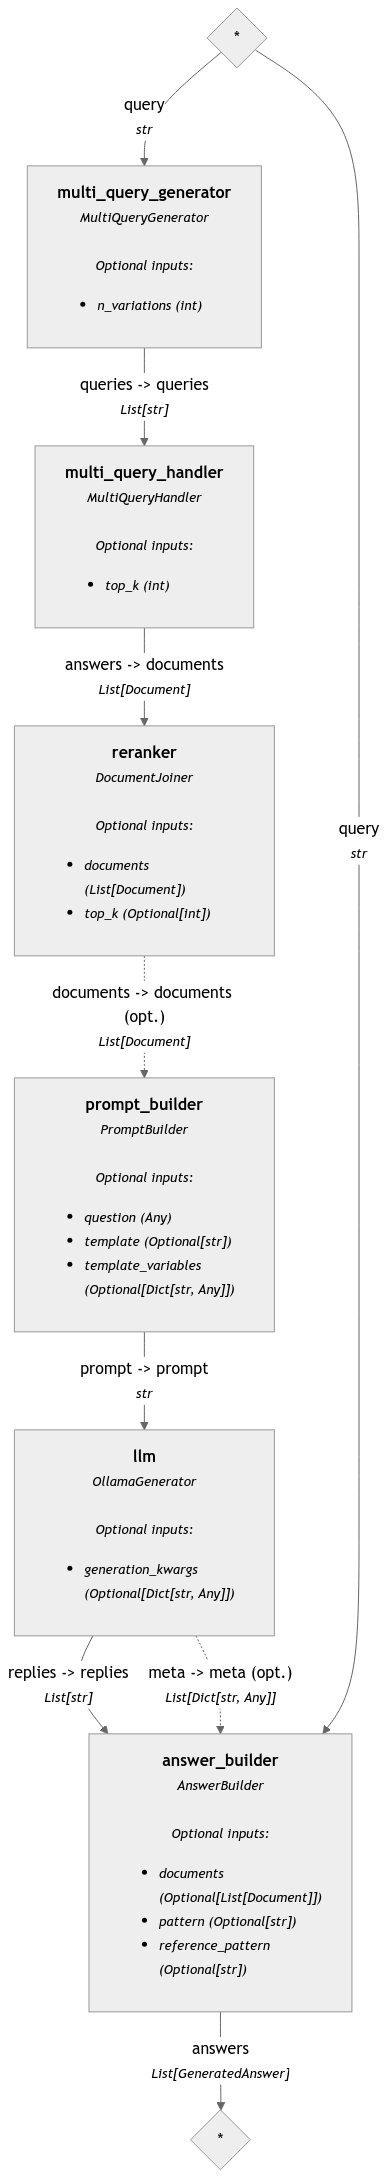

In [10]:
pipeline.show()

In [15]:
question = "Can you give me some suggestions do you have for Christmas presents? Please provide a variety of options."
question = "What is popular in the music industry today?"
#question = "How are cybersecurity threats evolving with new technologies?"
#question = "What does UK do to prevent piracy in music industry?"

n_variations = 3
top_k = 3

result = pipeline.run(
    {'multi_query_generator':{'query':question, 'n_variations':n_variations},
     'multi_query_handler':{'top_k':top_k},
     'prompt_builder': {'template_variables': {'question':question}},
     'answer_builder':{'query':question}
     }, include_outputs_from={"multi_query_generator"}
)

Batches: 100%|██████████| 1/1 [00:00<00:00, 184.11it/s]


Print the answer and the queries used to retrieve more data

In [16]:
print("\n\nQuestions:\n")
for q in result['multi_query_generator']['queries']:
    print(q)
print("\n\nAnswer:\n")
print(result['answer_builder']['answers'][0].data)



Questions:

What is popular in the music industry today?
What musical genres are currently trending on streaming platforms?
How do contemporary artists collaborate with producers and songwriters?
What role do social media influencers play in promoting emerging musicians?


Answer:

Based on the text, several trends and topics appear to be popular in the music industry:

1. Hip-hop music, particularly through Kanye West's successful solo album "The College Dropout" and his collaborations with other artists.
2. The use of samples from various songs, including classic rock and R&B tracks, in hip-hop music.
3. Reggae music, despite a recent controversy surrounding homophobic lyrics.
4. The commercial success of dancehall reggae stars, such as Beenie Man, Sizzla, and Elephant Man.

Overall, it seems that hip-hop is currently a dominant force in the music industry, with West's innovative production style and collaborations contributing to its popularity.
